<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Topic Modeling
## *Data Science Unit 4 Sprint 1 Assignment 4*

Analyze a corpus of Amazon reviews from Unit 4 Sprint 1 Module 1's lecture using topic modeling: 

- Fit a Gensim LDA topic model on Amazon Reviews
- Select appropriate number of topics
- Create some dope visualization of the topics
- Write a few bullets on your findings in markdown at the end
- **Note**: You don't *have* to use generators for this assignment

#### 1) Fit a gensim LDA topic model on Amazon Reviews 

In [10]:
import pandas as pd
import numpy as np
import gensim
import os
import re

from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora

from gensim.models.ldamulticore import LdaMulticore

import matplotlib.pyplot as plt

df = pd.read_csv('../module1-text-data/data/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv')

In [22]:
## Get reviews from df
STOPWORDS = set(STOPWORDS).union(set(['amazon', 'use', 'batteries']))

def tokenize(text):
    return [token for token in simple_preprocess(text) if token not in STOPWORDS]

tokenize(df['reviews.text'][0])

['order',
 'item',
 'bad',
 'quality',
 'missing',
 'backup',
 'spring',
 'pcs',
 'aluminum',
 'battery',
 'work']

In [63]:
# create a doc stream of the reviews -- yielding tokens
    
def gather_data(reviews):
    
    data = []
    
    for r in reviews: 
        
        tokens = tokenize(str(reviews))
        data.append(tokens)
    
    return data

In [64]:
## get a dictionary going

id2word = corpora.Dictionary(gather_data(df['reviews.text']))

In [48]:
# Let's remove extreme extremies

id2word.filter_extremes(no_below=5, no_above=0.85)

In [67]:
# a bag of words(bow) representation of our corpus
# Note: we haven't actually read any text into memory here - using generator

corpus = [id2word.doc2bow(review) for review in gather_data(df['reviews.text'])]

#corpus = [id2word.doc2bow(text) for text in doc_stream(path)]

In [70]:
lda = LdaMulticore(corpus=corpus,
                  id2word=id2word,
                  random_state=42,
                  num_topics=15,
                  workers=4
                  )

In [71]:
words = [re.findall(r'"([^"]*)"',t[1]) for t in lda.print_topics()]

In [75]:
topics = [' '.join(t[1:5]) for t in words]

In [90]:
print(topics[2])

batteries amazon use tablet


#### select appropriate number of topics

In [82]:
from gensim.models.coherencemodel import CoherenceModel

def compute_coherence_values(dictionary, corpus, path, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    path : path to input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        stream = gather_data(path)
        model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=id2word, workers=4)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=stream, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [83]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        path=df['reviews.text'], 
                                                        start=2, 
                                                        limit=40, 
                                                        step=6)

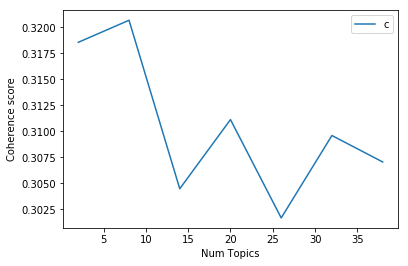

In [84]:
# Show graph
# looking for elbow, to pick best number of topics

limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [85]:
# from previous graph.. looks like about 8 might be good amount of topics

lda = LdaMulticore(corpus=corpus,
                  id2word=id2word,
                  random_state=42,
                  num_topics=8,
                  workers=4
                  )

#### create visualization of topics

In [86]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()

In [88]:

pyLDAvis.gensim.prepare(lda, corpus, id2word)

/Users/lambda_school_loaner_95/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.000625  0.004492       1        1  14.276616
7      0.002855  0.000351       2        1  13.339223
5     -0.000808 -0.001673       3        1  12.796424
3      0.000423 -0.001633       4        1  12.414340
0     -0.004790  0.000615       5        1  12.238459
1      0.001302  0.000768       6        1  11.892346
6      0.002306 -0.001922       7        1  11.593270
2     -0.001912 -0.000997       8        1  11.449319, topic_info=    Category           Freq       Term          Total  loglift  logprob
129  Default  143402.000000     tablet  143402.000000  30.0000  30.0000
63   Default  227950.000000      great  227950.000000  29.0000  29.0000
19   Default  253139.000000  batteries  253139.000000  28.0000  28.0000
116  Default   86790.000000    product   86790.000000  27.0000  27.0000
85   Default  141906.000000       long  141906.000000  26.0000  26.0000
138  Default  194563.000000        use  194563.000000  25.0000  25.0000
82   Default   85841.000000      light   85841.000000  24.0000  24.0000
43   Default   58095.000000   duracell   58095.000000  23.0000  23.0000
21   Default   29764.000000      begin   29764.000000  22.0000  22.0000
20   Default   85780.000000    battery   85780.000000  21.0000  21.0000
146  Default   85949.000000      works   85949.000000  20.0000  20.0000
118  Default  113447.000000    reading  113447.000000  19.0000  19.0000
93   Default   56943.000000       need   56943.000000  18.0000  18.0000
7    Default  168129.000000     amazon  168129.000000  17.0000  17.0000
74   Default   83787.000000       kids   83787.000000  16.0000  16.0000
26   Default   85450.000000      brand   85450.000000  15.0000  15.0000
107  Default   28927.000000    parenta   28927.000000  14.0000  14.0000
64   Default   58025.000000         hd   58025.000000  13.0000  13.0000
51   Default   56569.000000       fast   56569.000000  12.0000  12.0000
29   Default   56780.000000        buy   56780.000000  11.0000  11.0000
102  Default   85677.000000        old   85677.000000  10.0000  10.0000
142  Default   28573.000000      wants   28573.000000   9.0000   9.0000
99   Default   28848.000000     ninety   28848.000000   8.0000   8.0000
75   Default  111282.000000     kindle  111282.000000   7.0000   7.0000
84   Default   29134.000000       like   29134.000000   6.0000   6.0000
88   Default   57685.000000       love   57685.000000   5.0000   5.0000
145  Default  110682.000000       work  110682.000000   4.0000   4.0000
121  Default   28413.000000    reviews   28413.000000   3.0000   3.0000
111  Default   29020.000000    playing   29020.000000   2.0000   2.0000
139  Default   57411.000000         ve   57411.000000   1.0000   1.0000
..       ...            ...        ...            ...      ...      ...
14    Topic8    3638.099121        bad   28141.708984   0.1214  -5.3320
18    Topic8    3675.083496   batterie   28432.925781   0.1213  -5.3219
38    Topic8    3675.258789    comment   28463.554688   0.1202  -5.3219
81    Topic8    3716.326172    library   28819.914062   0.1189  -5.3108
85    Topic8   18010.845703       long  141906.171875   0.1030  -3.7325
7     Topic8   21105.033203     amazon  168129.656250   0.0920  -3.5740
129   Topic8   17867.263672     tablet  143402.484375   0.0846  -3.7405
63    Topic8   27870.527344      great  227950.375000   0.0657  -3.2959
61    Topic8   10686.906250       good   85188.140625   0.0914  -4.2545
118   Topic8   13829.266602    reading  113447.984375   0.0627  -3.9967
105   Topic8    7044.053711      order   55897.285156   0.0959  -4.6713
139   Topic8    7211.078613         ve   57411.996094   0.0926  -4.6479
24    Topic8    7065.236328      books   56986.234375   0.0796  -4.6683
19    Topic8   24586.443359  batteries  253139.750000  -0.1645  -3.4213
138   Topic8   19484.298828        use  194563.921875  -0.1339  -3.6539
26    Topic8    9759.736328      

In [93]:
words = [re.findall(r'"([^"]*)"',t[1]) for t in lda.print_topics()]

In [100]:
topics = [' '.join(t[1:10]) for t in words]

In [101]:
topics[1]

'great amazon use work bought long works got tablet'

In [102]:
distro = [lda[d] for d in corpus]

In [104]:
def update(doc):
    d_dist = {k:0 for k in range(0,3)}
    for t in doc:
        d_dist[t[0]] = t[1]
    return d_dist

new_distro = [update(d) for d in distro]

In [116]:
df_distro = pd.DataFrame.from_records(new_distro, index=df['id'])
df_distro.columns = topics

In [117]:
df_distro.tail()

,great batteries amazon use bought long reading got kids,great amazon use work bought long works got tablet,batteries amazon use long tablet bought reading got kindle,batteries amazon use long tablet bought kindle got light,use amazon great bought work got long reading kindle,batteries great tablet long amazon bought kindle reading work,use great long amazon tablet product bought reading kindle,great use long bought amazon reading kindle work got
id,,,,,,,,
AVqkIhxunnc1JgDc3kg_,0.162696,0.159568,0.084152,0.124596,0.087349,0.135940,0.142181,0.103518
AVqkIhxunnc1JgDc3kg_,0.178872,0.135437,0.037802,0.132062,0.210920,0.066508,0.097381,0.141019
AVqkIhxunnc1JgDc3kg_,0.111777,0.121719,0.102105,0.062719,0.158951,0.146605,0.129959,0.166166
AVqkIhxunnc1JgDc3kg_,0.069217,0.111261,0.113136,0.129467,0.247807,0.150692,0.071152,0.107268
AVqkIhxunnc1JgDc3kg_,0.110169,0.079453,0.129225,0.154483,0.127000,0.137739,0.068729,0.193203


## Stretch Goals

* Incorporate Named Entity Recognition in your analysis
* Incorporate some custom pre-processing from our previous lessons (like spacy lemmatization)
* Analyze a dataset of interest to you with topic modeling